# Snapshot Analytics (Time Series)

This notebook shows how to run a Snapshot Explain operation with the minimal steps and a simple query.

In this notebook...
* [Dependencies and Initialisation](#dependencies-and-initialisation)
* [The Where Statement](#the-where-statement)
* [Analytics Query Options](#analytics-query-options)
* [Running the Analytics Operation](#running-the-analytics-operation)
* [Quick view of the returned Time-Series](#quick-view-of-the-returned-time-series)
* [Next Steps](#next-steps)

**_NOTE_**: This notebook was tested using the [`factiva-analytics`](https://factiva-analytics-python.readthedocs.io/) Python package version **0.3.13** (Sep 2024) and [Factiva Analytics v3.0](https://developer.dowjones.com/site/docs/factiva_apis/factiva_analytics_apis/factiva_snapshots_api/snapshots_3_0/index.gsp#) endpoints.

## Dependencies and Initialisation
Import statements and environment initialisation using the package `dotenv`. More details in the [Configuration notebook](0.2_configuration.ipynb).

In [1]:
import factiva.analytics as fa
from factiva.analytics import SnapshotTimeSeries
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()
print(f"Using the Factiva Analytics Python Package version {fa.__version__}")

Using the Factiva Analytics Python Package version 0.3.13


## The Where Statement

This notebook uses a simple query for illustration purposes. For more tips about queries, or guidance on how to build complex or large queries, checkout the [Complex and Large Queries](2.1_complex_large_queries.ipynb) notebook.

In [2]:
# Industry i3432 is for Batteries
where_statement = (
    r" publication_datetime >= '2016-01-01 00:00:00' "
    r" AND LOWER(language_code) IN ('en', 'de', 'fr') "
    r" AND REGEXP_CONTAINS(industry_codes, r'(?i)(^|,)(i3432)($|,)') "
)

s = SnapshotTimeSeries(query=where_statement)

## Analytics Query Options

An analytics job works under the same logic as the Explain job. It means that no extractions are decremented from the allowance, and results consist of a time-series volume estimates. The analytics result allows to get a more detailed view of the used criteria in order to fine-tune the query.

In the case of analytics, the query uses more parameters to group and summarise the results:

* **`frequency`**: _Optional_, _Default: `'MONTH'`_. Frequency to aggregate results. Possible values are `'MONTH'`, `'YEAR'` or `'DAY'`. Used only by the Analytics operation.
* **`date_field`**: _Optional_, _Default: `'publication_datetime'`_. Date-time field used to aggregate. Possible values are `'publication_datetime'`, `'ingestion_datetime'` and `'modification_datetime'`. Used only by the Analytics operation.
* **`group_dimensions`**: _Optional_, _Default: `[]`_. Specifies if the frequency totals are provided as a whole number of if are broken-down by the chosen dimensions. This field can contain up to 4 values from the available dimensions:
    * source_code
    * subject_codes
    * region_codes
    * industry_codes
    * company_codes
    * person_codes
    * company_codes_about
    * company_codes_relevance
    * company_codes_cusip
    * company_codes_isin
    * company_codes_sedol
    * company_codes_ticker
    * company_codes_about_cusip
    * company_codes_about_isin
    * company_codes_about_sedol
    * company_codes_about_ticker
    * company_codes_relevance_cusip
    * company_codes_relevance_isin
    * company_codes_relevance_sedol
    * company_codes_relevance_ticker
* **`top`**: Valid only if ```group_dimensions``` is set. Sets the limit for the top values by dimension and frequency.

**Note:**, the sum of broken-down volumes in Analytics may not add up to the total displayed with the Explains operation. This is expected given the fact that articles tagged with multiple values are counted multiple times in the returned time-series dataset.

In [3]:
s.query.frequency = 'YEAR'
s.query.date_field = 'publication_datetime'
s.query.group_dimensions = ['source_code']
s.query.top = 10

## Running the Analytics Operation

This operation returns document volume time-series matching provided query in the Factiva Analytics archive. The goal of this operation is to have a more precise idea of the document volume and distribution over time. When used iteratively, helps deciding if by adding/deleting/modifying the criteria has impact on the matching estimates.

The `<SnapshotTimeSeries>.process_job()` function wraps the whole process and directly returns the time-series dataset. If a more manual process is required (run submit, monitor and get job results as separate operations), please see the [detailed package documentation](https://factiva-analytics-python.readthedocs.io/).

In [4]:
%%time
s.process_job()
print('Done!')

Done!
CPU times: user 93.9 ms, sys: 2.5 ms, total: 96.4 ms
Wall time: 35.4 s


## Quick view of the returned Time-Series
Restuls are stored in the `<Snapshot>.last_analytics_job.data` property. It is a Pandas DataFrame with the time-series fields and values.

In [5]:
s.job_response.data

,publication_datetime,count,source_code
0,2016,279,CHEMEC
1,2016,474,JOENG
2,2016,425,SEENDI
3,2016,299,TDLY
4,2016,1103,GLOMCP
...,...,...,...
85,2024,1111,LBA
86,2024,604,SAEXC
87,2024,1173,LCDVP
88,2024,1688,DJDN


Using the out-of-the-box features of Pandas, the following code plots the output (filtered to the used columns) in a chart.

This code requires `matplotlib` to be installed in running Python environment.

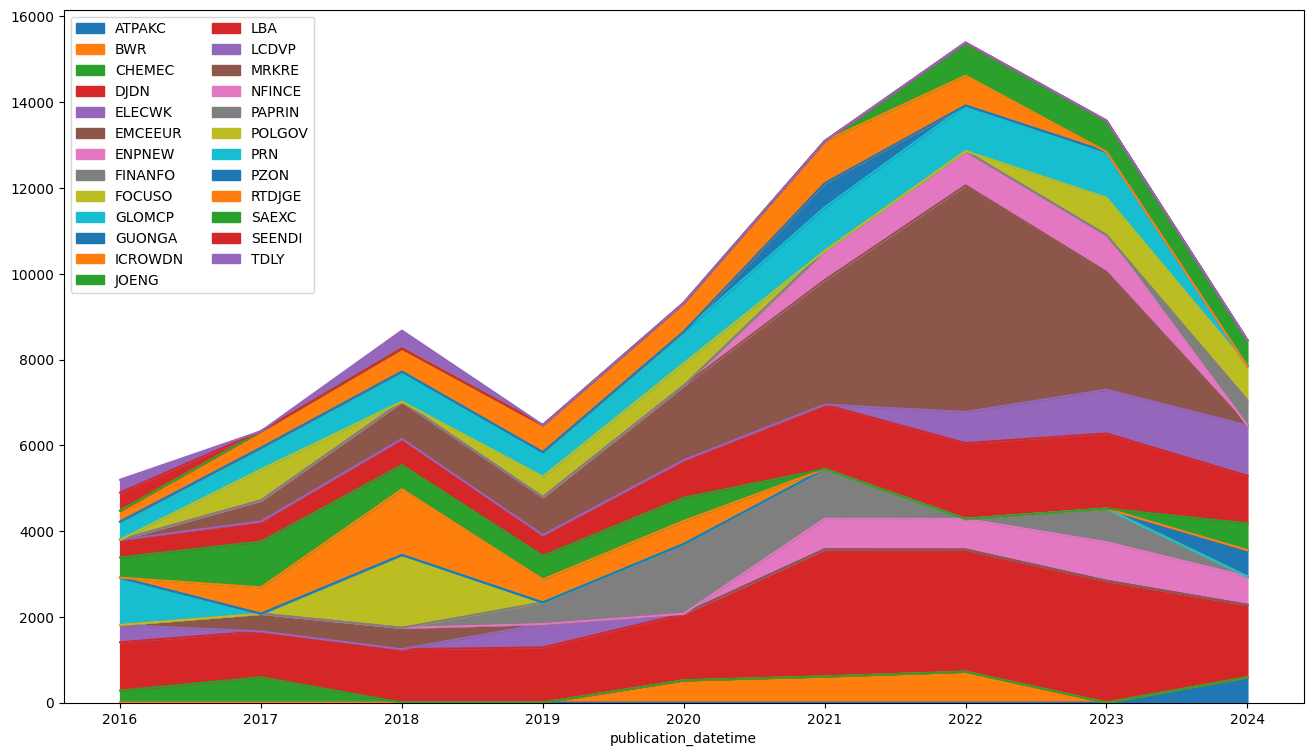

In [6]:
stck_data = s.job_response.data.pivot(index='publication_datetime', columns=['source_code'], values='count')
stck_data.plot(kind='area', stacked=True, figsize=(16, 9))
plt.legend(loc='upper left', ncols=2)
plt.show()

## Full code for v3

```python
import requests as r
import json
import time
import os
import pandas as pd

USERKEY_FROM_ENV = os.environ['FACTIVA_USERKEY']
URL_BASE = 'https://api.dowjones.com'

req_headers = {
    'user-key': USERKEY_FROM_ENV,
    'Content-Type': 'application/json',
    'X-API-VERSION': '3.0'
}

where_statement =  (
                    r" publication_datetime >= '2024-01-01 00:00:00' "
                    r" AND publication_datetime < '2024-02-01 00:00:00' "
                    r" AND REGEXP_CONTAINS(subject_codes, r'(?i)(^|,)(cprdcl|c16|cbro)($|,)') "
                    r" AND REGEXP_CONTAINS(region_codes, r'(?i)(^|,)(spain|italy)($|,)') "
 )


def submit_ts_job(where=None):
    req_payload = {
        'query': {
            'where': where,
            'frequency': 'MONTH',
            'date_field': 'publication_datetime',
            'group_dimensions': ['source_code'],
            'top': 20,
        }
    }

    submit_job_url = f"{URL_BASE}/analytics/"
    submit_job_resp =  r.post(submit_job_url, headers=req_headers, data=json.dumps(req_payload))
    submit_job_resp_dict = submit_job_resp.json()
    return submit_job_resp_dict['data']['id'], submit_job_resp_dict['data']['attributes']['current_state']


def get_job_results(id=None, state=None):
    while state != 'JOB_STATE_DONE':
        if state == 'JOB_STATE_FAILED':
            raise Exception('Job failed')
        time.sleep(10)
        get_job_url = f"{URL_BASE}/analytics/{job_id}"
        get_job_resp = r.get(get_job_url, headers=req_headers)
        get_job_resp_dict = get_job_resp.json()
        state = get_job_resp_dict['data']['attributes']['current_state']
    return get_job_resp_dict['data']['attributes']['download_link']


def get_ts_data(link=None):
    get_data_resp = r.get(link, headers=req_headers)
    return pd.DataFrame(get_data_resp.json()['data']['attributes']['results'])


if __name__ == '__main__':

    print('Submitting Job...')
    job_id, job_state = submit_ts_job(where_statement)
    print(f"Job submitted. ID: {job_id}")

    print(f"Monitoring Job with ID {job_id}")
    download_link = get_job_results(id=job_id, state=job_state)
    print(f"Link: {download_link}")

    ts_data = get_ts_data(download_link)
    print(ts_data)
```

# Next Steps

* Run an [explain](1.4_snapshot_explain.ipynb) to estimate the exact number of articles that match the tested criteria.
* Run an [extraction](1.6_snapshot_extraction.ipynb) and download the matching content.
* Fine-tune the query by adding/modifying the query criteria (where_statement) according to the [query reference](2.1_complex_large_queries.ipynb).